# Session 2 - Multi-Armed Bandits - Assignment

In this assignment you will apply different multi-armed bandit algorithms in order to discover the bandit with highest reward.
We'll start with deterministic bandits, meaning that the bandit rewards are not subject to any underlying stochastic process.
Next we'll focuss on stochastic bandits where the reward of a bandit is the result of a stochastic process and therefore making the discovery of the best bandit much harder. 
Finally we will applay the MAB strategies to solve practical real-life problems.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def update_means(new_value, current_mean, count):
    if(count == 0):
        return new_value
    return current_mean + ((new_value - current_mean) / count)

## Deterministic bandits
Assume you have to play 5 bandits with fixed rewards. These rewards are hidden and unknown when you start playing. 
You can play the bandits 100 times. Find out how you can maximize your total reward over these 100 trials.

Use the BanditEnv_1 environment for this experiment.

In [3]:
##### Deterministic Bandit Environment

class BanditEnv_1:
    def __init__(self):
        self.rewards = [-10,6,8,0,-2]
        
    def reset(self):
        self.rewards = [-10,6,8,0,-2]
        
    def step(self,action):
        self.action = action
        return self.rewards[self.action]

In [4]:
# Create an Env1 object
Env1 = BanditEnv_1()
Env1.reset()

In [5]:
# Taken an action. For example choose bandit 0
reward = Env1.step(0)
print('reward =', reward)

reward = -10


If you know in advance that the bandits have fixed rewards, the best strategy will be to play them all once and then pick the one with the highest reward (greedy action).

[-10, 6, 8, 0, -2]
Bandit with the highest reward is bandit 2 with a reward of 8
The total reward =  710


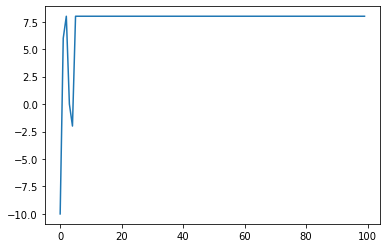

In [6]:
rewards = []
totalReward = 0
for action in range(5):
    rewards.append(Env1.step(action))
    totalReward = totalReward + reward
    
print(rewards)
bestAction = np.argmax(rewards)
print('Bandit with the highest reward is bandit',bestAction, 'with a reward of',rewards[bestAction])

for i in range(100 - 5):
    rewards.append(Env1.step(bestAction))
    totalReward = totalReward + Env1.step(bestAction)

print('The total reward = ', totalReward)

# Plot the rewards as a funtion of the number of trials
plt.plot(rewards)

## Stochastic bandits

In the case of stochastic bandits, the reward is sampled from an initially unknown distribution. Our task is to discover the expected reward of each of the bandits as quickly (and reliably) as possible. 
As an example, assume that the reward of a bandit comes from a normal distribution with mean = 10 and standard deviation of 5. This means that in 68% procent of the trials this bandit will return a reward between 10-5 = 5 and 10+5 = 15. If you play this bandit multiple times, you can expect that the average reward will converge to 10.

Use BanditEnv_2 for this exercise. All 5 bandits have rewards coming from normal distributions with different means, but with the same standard deviation (std = 1).
You can play this bandit 200 times. Try to come up with a good strategy to maximize the total reward over these 200 trials.

In [7]:
class BanditEnv_2:
    def __init__(self, std = 1):
        self.means = [-10,6,8,0,-2]
        self.std = std
        
    def reset(self, std = 1):
        self.means = [-10,6,8,0,-2]
        self.std = std

    def change_means(self, mns):
        self.means = mns
        
    def step(self,action):
        self.action = action
        return np.random.normal(self.means[self.action], self.std, 1)[0]
    
    def possible_actions(self):
        return np.arange(len(self.means), dtype=int)

In [8]:
# Create an Env2 object
greedy_env = BanditEnv_2()
greedy_env.reset()
print(greedy_env.means)

[-10, 6, 8, 0, -2]


**Explanation**

- First, we are defining a percentage of the total iterations that we will dedicate to the exploration phase.  
- Then we round-robin the different bandits, during that phase, and use the computational optimization to keep track of the average reward per bandit. 
- After the exploration, we exploit the best bandit and keep trying that one

In [9]:
def learn_greedy(env, exploration):
    print('-----------')
    print(f'Learn greedy with exploration {exploration}')
    iterations = 200
    bandits = len(env.possible_actions())
    bandit_means = np.zeros((bandits,2))
    total_reward = 0
    averages = []

    # Exploration phase
    exploration_attempts = round(iterations * exploration)
    for i in range(exploration_attempts):
        # picking action now, based on mod
        current_bandit = i % bandits
        current_reward = env.step(current_bandit)
        total_reward += current_reward
        attempt = (i - current_bandit) / bandits
        bandit_means[current_bandit, 0] = update_means(current_reward, bandit_means[current_bandit, 0], bandit_means[current_bandit, 1])
        bandit_means[current_bandit, 1] = bandit_means[current_bandit, 1] + 1
        if i==0 :
            averages.append(total_reward)
        else:
            averages.append(total_reward / i)

    # Results after exploration phase
    best_bandit = np.argmax(bandit_means[:,0])
    print(f'Results after exploration, best action is {best_bandit}')

    # Continue rest of exploitation with best bandit
    for i in range(iterations - exploration_attempts):
        current_reward = env.step(best_bandit)
        total_reward += current_reward
        averages.append(total_reward / (exploration_attempts+i))
        bandit_means[best_bandit, 0] = update_means(current_reward, bandit_means[best_bandit, 0], bandit_means[best_bandit, 1])
        bandit_means[best_bandit, 1] = bandit_means[best_bandit, 1] + 1
        
    print(f'Total reward for all iterations: {total_reward}')
    print(f'Total attempts per action: {bandit_means[:,1]}')
    plt.plot(averages, label = f'Greedy {exploration}')
    return np.array(averages), bandit_means


-----------
Learn greedy with exploration 0.05
Results after exploration, best action is 2
Total reward for all iterations: 1524.6017843086936
Total attempts per action: [  2.   2. 192.   2.   2.]
-----------
Learn greedy with exploration 0.1
Results after exploration, best action is 2
Total reward for all iterations: 1465.7451455099235
Total attempts per action: [  4.   4. 184.   4.   4.]
-----------
Learn greedy with exploration 0.25
Results after exploration, best action is 2
Total reward for all iterations: 1229.8241703010717
Total attempts per action: [ 10.  10. 160.  10.  10.]
-----------
Learn greedy with exploration 0.33
Results after exploration, best action is 2
Total reward for all iterations: 1089.6653503188675
Total attempts per action: [ 14.  13. 147.  13.  13.]
-----------
Learn greedy with exploration 0.5
Results after exploration, best action is 2
Total reward for all iterations: 849.8022880435337
Total attempts per action: [ 20.  20. 120.  20.  20.]
-----------
Learn 

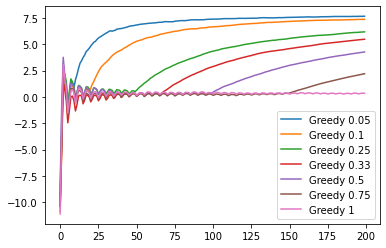

In [10]:
for exploration in [.05, .1, .25, .33, .5, .75, 1]:
    learn_greedy(greedy_env, exploration)
_ = plt.legend()

### Epsilon Greedy

1. Implement the epsilon greedy algorithm to play the Env2 bandits. 
    - **See below**
2. Show the influence of epsilon parameter. Do this by plotting the reward history for different values of epsilon. Also visualize how often a bandit was chosen.
    - **See plot. The lower the epsilon gets, the less exploration happens and the higher the result typically will be.  But the risk of selecting the second highest bandit is real.**
3. Find the optimal epsilon value giving you maximum total reward.
    - **Seems around 10% has best reward**
4. Use epsilon decay. This means that you gradually decrease the value of epsilon as the number of trials increases. Use the following rule: $\epsilon(t+1) = \eta \times \epsilon(t) $ where $0< \eta < 1$
    - **Added this as an argument in the method, and extra cell showing the impact.**
5. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
    - **In order to improve results, the epsilon value will have to be increased, to avoid too much noise and variations**

In [11]:
epsilons = [0.05, 0.1, 0.2, 0.5, 0.9]

In [12]:
import random
def pick_eg_action(epsilon: float, current_means: np.array, possible_actions: np.array, use_decay: bool = True, iteration: int = 0, total_iterations = 200):
    adjusted_eps = epsilon
    if use_decay:
        adjusted_eps = epsilon * ((total_iterations - iteration) / total_iterations)
    if(random.random() <= adjusted_eps):
        return np.random.choice(possible_actions)
    else:
        return np.argmax(current_means[:,0])

In [13]:
def learn_epsgreedy(epsilon_env, epsilon: float, use_decay: bool = False):
    print('-----------')
    print(f'Learn with epsilon greedy {epsilon}')
    iterations = 200
    averages = []
    bandits = len(epsilon_env.possible_actions())
    bandit_means = np.zeros((bandits,2))
    total_reward = 0
    
    for i in range(0, iterations) :
        current_bandit = pick_eg_action(epsilon, bandit_means, epsilon_env.possible_actions(), use_decay=use_decay, iteration=i, total_iterations=iterations)
        current_reward = epsilon_env.step(current_bandit)
        total_reward += current_reward
        bandit_means[current_bandit, 0] = update_means(current_reward, bandit_means[current_bandit, 0], bandit_means[current_bandit, 1])
        bandit_means[current_bandit, 1] = bandit_means[current_bandit, 1] + 1
        if i==0 :
            averages.append(total_reward)
        else:
            averages.append(total_reward / i)

    # Results 
    best_bandit = np.argmax(bandit_means[:,0])
    print(f'Total reward for all iterations: {total_reward}, and best action is {best_bandit}')
    print(f'Total attempts per action: {bandit_means[:,1]}')
    plt.plot(averages, label = str(epsilon))
    return np.array(averages), bandit_means

**Normal epsilon greedy , without decay**

- In the following cells, I am learning by applying the Epsilon greedy approach, with several epsilon values.
- The results (averages, total reward and attempts per bandit) are printed or plotted.

In [14]:
# Create an Env2 object
eps_env = BanditEnv_2()
eps_env.reset()
print(eps_env.means)
print(eps_env.possible_actions())

[-10, 6, 8, 0, -2]
[0 1 2 3 4]


-----------
Learn with epsilon greedy 0.05
Total reward for all iterations: 1389.7866148020416, and best action is 2
Total attempts per action: [  4.  44. 149.   1.   2.]
-----------
Learn with epsilon greedy 0.1
Total reward for all iterations: 1238.7927649457417, and best action is 2
Total attempts per action: [ 11.  44. 138.   3.   4.]
-----------
Learn with epsilon greedy 0.2
Total reward for all iterations: 1306.5080132924645, and best action is 2
Total attempts per action: [  4.  21. 154.  13.   8.]
-----------
Learn with epsilon greedy 0.5
Total reward for all iterations: 797.2124640280857, and best action is 2
Total attempts per action: [ 23.  22. 118.  22.  15.]
-----------
Learn with epsilon greedy 0.9
Total reward for all iterations: 161.07310260085035, and best action is 2
Total attempts per action: [36. 34. 51. 36. 43.]


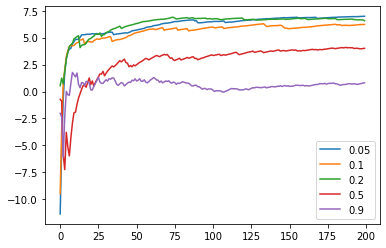

In [15]:
import matplotlib.pyplot as plt
for epsilon in epsilons:
    learn_epsgreedy(eps_env, epsilon)

plt.legend()

**Epsilon greedy , with decay**

- In the following cells, I am learning by applying the Epsilon greedy approach, with several epsilon values, and applying a linear decay.
- The results (averages, total reward and attempts per bandit) are printed or plotted.

-----------
Learn with epsilon greedy 0.05
Total reward for all iterations: 1129.9349230132104, and best action is 1
Total attempts per action: [  3. 195.   0.   1.   1.]
-----------
Learn with epsilon greedy 0.1
Total reward for all iterations: 1341.8092710771602, and best action is 2
Total attempts per action: [  1. 120.  77.   1.   1.]
-----------
Learn with epsilon greedy 0.2
Total reward for all iterations: 1455.5639314987045, and best action is 2
Total attempts per action: [  4.  13. 178.   1.   4.]
-----------
Learn with epsilon greedy 0.5
Total reward for all iterations: 1201.7104419572881, and best action is 2
Total attempts per action: [ 14.  12. 163.   4.   7.]
-----------
Learn with epsilon greedy 0.9
Total reward for all iterations: 1097.6505822187744, and best action is 2
Total attempts per action: [  9.  16. 141.  13.  21.]


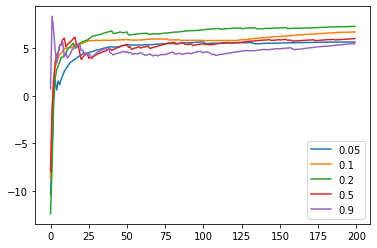

In [16]:
import matplotlib.pyplot as plt
eps_env.reset()
for epsilon in epsilons:
    learn_epsgreedy(eps_env, epsilon, True)

_ = plt.legend()

**Epsilon greedy , with decay , and std of 2**

- In the following cells, I am learning by applying the Epsilon greedy approach with decay, with several epsilon values.
- But the environment has changed, so that the stddev of every bandit is bigger
- The results (averages, total reward and attempts per bandit) are printed or plotted.

In [17]:
# Create an Env2 object
eps_env = BanditEnv_2(2)
eps_env.reset(2)

-----------
Learn with epsilon greedy 0.05
Total reward for all iterations: 1168.2567769311486, and best action is 1
Total attempts per action: [  1. 195.   0.   2.   2.]
-----------
Learn with epsilon greedy 0.1
Total reward for all iterations: 1452.0582338958247, and best action is 2
Total attempts per action: [  2.  24. 171.   0.   3.]
-----------
Learn with epsilon greedy 0.2
Total reward for all iterations: 1349.9435876576738, and best action is 2
Total attempts per action: [  4.  33. 153.   3.   7.]
-----------
Learn with epsilon greedy 0.5
Total reward for all iterations: 1011.2002378804482, and best action is 2
Total attempts per action: [ 17.  11. 140.  16.  16.]
-----------
Learn with epsilon greedy 0.9
Total reward for all iterations: 839.936166089978, and best action is 2
Total attempts per action: [ 21.  14. 129.  14.  22.]


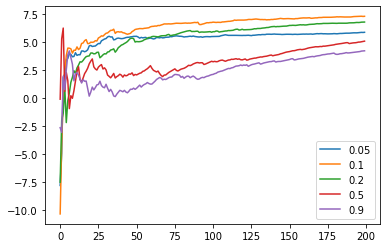

In [18]:
import matplotlib.pyplot as plt

for epsilon in epsilons:
    learn_epsgreedy(eps_env, epsilon, True)

_ = plt.legend()

### Optimistic Initial Value

Continue to work with the Env2 environment. 
Implement the Optimistic Initial Value algorithm. Start by initializing the estimated bandit means to a high non-zero value and use a greedy approach. 
After each play the estimated bandit mean will come closer to the true bandit mean.

1. Implement the optimistic initial value algorithm to play the Env2 bandits. Check the final values of the estimated means.
    - **See code cells below**
2. Show the initialization. What happens if you initialize the estimated means to larger values? 
    - **When doing so, it is obviously important the initial value is high enough, and it takes a bit more iterations to diverge to picking the right bandit.  When a higher value is taken, it means the exploration phase will be longer, the lower the initial value, the less exploration is needed.**
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
    - **It seems the average reward diverges to a higher value in that case, this can be seen in the cells below, where the impact is plotted.  Having a higher stddev also requires more exploration, as the variation becomes much higher, of the bandits.**
4. Compare the optimistic initial value approach to the epsilon greedy approach. Plot the reward history of both in one graph.
    - **See last cell in this section**



#### Reusable code that implements the model

In [19]:
# Create an Env2 object
oiv_env = BanditEnv_2()
oiv_env.reset()

In [20]:
# Optimistic initial value

def learn_optimistic(env, initial_value = 10000, print_attempts: bool = False, plot_label: str = None):
    if plot_label == None:
        plot_label = f'Opt I.V. {initial_value}'
    print('-----------')
    print(f'Learn with Optimistic value {initial_value}')
    iterations = 200
    # Initialize to high value (the optimistic initial value)
    bandits = len(env.possible_actions())
    bandit_means = np.zeros((bandits,2))
    bandit_means[:, 0] =  initial_value
    bandit_means[:, 1] =  1
    averages = []
    total_reward = 0

    # Exploration phase
    for i in range(iterations):
        # picking action now, based on mod
        current_bandit = np.argmax(bandit_means[:,0])
        current_reward = env.step(current_bandit)
        total_reward += current_reward
        bandit_means[current_bandit, 0] = update_means(current_reward, bandit_means[current_bandit, 0], bandit_means[current_bandit, 1])
        bandit_means[current_bandit, 1] = bandit_means[current_bandit, 1] + 1
        if i==0 :
            averages.append(total_reward)
        else:
            averages.append(total_reward / i)

            # Results after exploration phase
    best_bandit = np.argmax(bandit_means[:,0])
    print(f'Results: best action is {best_bandit}')
    print(f'Total reward for all iterations: {total_reward}')
    print(f'Total attempts per action: {bandit_means[:,1]}')
    if print_attempts:
        print(bandit_means)
    plt.plot(averages, label = plot_label)
    return np.array(averages), bandit_means


#### Learn, with different initialization values

-----------
Learn with Optimistic value 1
Results: best action is 1
Total reward for all iterations: 1203.3455707801888
Total attempts per action: [  2. 200.   1.   1.   1.]
-----------
Learn with Optimistic value 10
Results: best action is 2
Total reward for all iterations: 1545.8131594605604
Total attempts per action: [  2.   2. 197.   2.   2.]
-----------
Learn with Optimistic value 50
Results: best action is 2
Total reward for all iterations: 1550.1521074981558
Total attempts per action: [  2.   2. 197.   2.   2.]
-----------
Learn with Optimistic value 100
Results: best action is 2
Total reward for all iterations: 1568.911488570369
Total attempts per action: [  2.   3. 196.   2.   2.]
-----------
Learn with Optimistic value 1000
Results: best action is 2
Total reward for all iterations: 1544.3821539551363
Total attempts per action: [  2.   4. 195.   2.   2.]


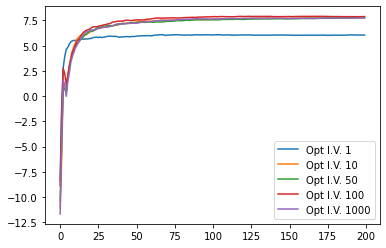

In [21]:
initials = [1, 10, 50, 100, 1000]
for initial in initials:
    oiv_env = BanditEnv_2()
    oiv_env.reset()
    learn_optimistic(oiv_env, initial, print_attempts = False)
_ = plt.legend()

#### Learn, with different std values in the bandit

Trying std 1
-----------
Learn with Optimistic value 10000
Results: best action is 2
Total reward for all iterations: 1566.2614261437868
Total attempts per action: [  2.   2. 197.   2.   2.]
Trying std 2
-----------
Learn with Optimistic value 10000
Results: best action is 2
Total reward for all iterations: 1527.8685060342325
Total attempts per action: [  2.   2. 197.   2.   2.]
Trying std 10
-----------
Learn with Optimistic value 10000
Results: best action is 1
Total reward for all iterations: 1330.8668849166186
Total attempts per action: [  2. 197.   2.   2.   2.]


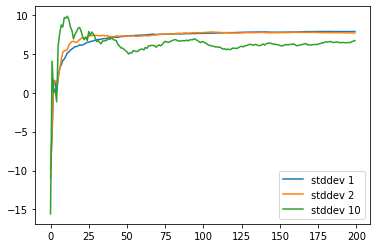

In [22]:
stds = [1, 2, 10]
for std in stds:
    print(f'Trying std {std}')
    oiv_env = BanditEnv_2(std)
    oiv_env.reset(std)
    learn_optimistic(oiv_env, 10000, False, f'stddev {std}')
_ = plt.legend()

#### Learn, with higher mean values in the bandit

-----------
Learn with Optimistic value 10000
Results: best action is 2
Total reward for all iterations: 176701.94400953306
Total attempts per action: [  2.   2. 197.   2.   2.]


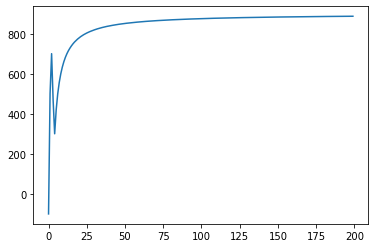

In [23]:
# Create an Env2 object
oiv_env = BanditEnv_2()
oiv_env.reset()
oiv_env.change_means([-100, 600, 900, 0, -200])
_ = learn_optimistic(oiv_env, 10000, False)

#### Compare greedy with this approach

-----------
Learn greedy with exploration 0.33
Results after exploration, best action is 2
Total reward for all iterations: 1075.9390578148198
Total attempts per action: [ 14.  13. 147.  13.  13.]
-----------
Learn greedy with exploration 0.1
Results after exploration, best action is 2
Total reward for all iterations: 1436.0416273234039
Total attempts per action: [  4.   4. 184.   4.   4.]
-----------
Learn with Optimistic value 1000
Results: best action is 2
Total reward for all iterations: 1542.1911780497585
Total attempts per action: [  2.   4. 195.   2.   2.]


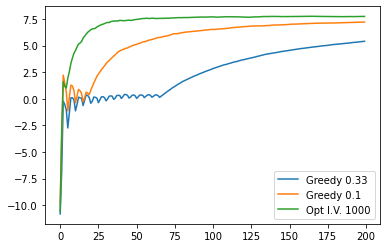

In [24]:
oiv_env = BanditEnv_2()
oiv_env.reset()

_ = learn_greedy(oiv_env, .33)
_ = learn_greedy(oiv_env, .1)
_ = learn_optimistic(oiv_env, 1000)
_ = plt.legend()

### Upper Confidence Bound

Continue to work with the Env2 environment and implement the Upper Confidence Bound algorithm. 
Select the action based on the following rule:

$A_t = argmax_a \left( MeanRewards + c  \sqrt{\frac{\ln{t}}{N_a(t)}}  \right)$

1. Implement the upper confidence bound algorithm to play the Env2 bandits. Check the final values of the estimated means.
    - **See code below**
2. Change the parameter c? Explain the influence of c. 
    - **The larger c becomes, the more exploration happens.  When means are quite different, it's more efficient to take a smaller c-value.  This is visible in the plotted averages of the curves**
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
    - **The higher the std dev becomes, the longer the exploration typically takes, which results in a lower overall (or average) reward**
4. Compare the upper confidence bound approach to the epsilon greedy approach and opimistic initial value. Plot the reward histories of the algorithms in one graph.
    - **See last plotted chart in this section.  Optimistic Initial Value and Upper Confidence Bound seem to be having the best results**


In [25]:
import math
def pick_ucb_action(c: float, current_means: np.array, iteration: int = 0):
    for bandit in range(current_means.shape[0]):
        bandit_mean = current_means[bandit, 0]
        bandit_attempts = current_means[bandit, 1]
        current_means[bandit, 2] = (bandit_mean + (c * math.sqrt(np.log(iteration) / bandit_attempts)))
    selected_action = np.argmax(current_means[:,2])
    return selected_action

In [26]:
# Create an Env2 object
UcbEnv = BanditEnv_2()
UcbEnv.reset()

In [27]:
def learn_upper_confident_bound(env, c: float, legend:str = None, print_means: bool = False):
    print('-----------')
    print(f'Learn with UCB method and c-value {c}')
    if legend == None:
        legend = f'Ucb {str(c)}'
    iterations = 200
    averages = []
    bandits = len(env.possible_actions())
    bandit_means = np.zeros((bandits,3))
    total_reward = 0
    
    for bandit in env.possible_actions():
        bandit_means[bandit, 0] = env.step(bandit)
        bandit_means[bandit, 1] = 1
        
    for i in range(bandits - 1, iterations) :
        selected_bandit = pick_ucb_action(c, bandit_means, i)
        current_reward = env.step(selected_bandit)
        total_reward += current_reward
        # Update means for the selected bandit with new reward
        bandit_means[selected_bandit, 0] = update_means(current_reward, bandit_means[selected_bandit, 0], bandit_means[selected_bandit, 1])
        # Increment number of attempts for the selected bandit
        bandit_means[selected_bandit, 1] = bandit_means[selected_bandit, 1] + 1
        averages.append(total_reward / i)

    # Results 
    best_bandit = np.argmax(bandit_means[:,0])
    print(f'Total reward for all iterations: {total_reward}, and best action is {best_bandit}')
    print(f'Total attempts per action: {bandit_means[:,1]}')
    if print_means:
        print(f'Expected means for bandits: {bandit_means[:,0]}')
        
    plt.plot(averages, label = legend)
    return np.array(averages), bandit_means

#### Test with different c-values

-----------
Learn with UCB method and c-value 0.5
Total reward for all iterations: 1547.2736454235906, and best action is 2
Total attempts per action: [  1.   2. 196.   1.   1.]
Expected means for bandits: [-10.81605911   5.51492847   7.90645496   0.30502165  -0.42919747]
-----------
Learn with UCB method and c-value 1
Total reward for all iterations: 1579.1126432674805, and best action is 2
Total attempts per action: [  1.   3. 195.   1.   1.]
Expected means for bandits: [-9.53651577  6.83632865  8.06927828  1.59283584 -0.75813386]
-----------
Learn with UCB method and c-value 2
Total reward for all iterations: 1560.463143896822, and best action is 2
Total attempts per action: [  1.   2. 196.   1.   1.]
Expected means for bandits: [-8.74119521  4.50827355  7.97925575 -0.12827823 -1.86985254]
-----------
Learn with UCB method and c-value 5
Total reward for all iterations: 1508.8395311035902, and best action is 2
Total attempts per action: [  1.  19. 177.   2.   2.]
Expected means for b

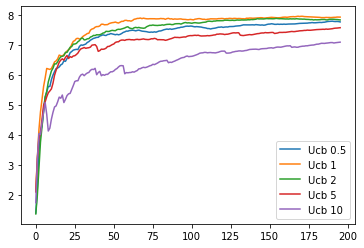

In [28]:
for c_value in [0.5, 1, 2, 5, 10]:
    learn_upper_confident_bound(UcbEnv, c_value, print_means = True)
_ = plt.legend()

#### Test with different standard deviations

-----------
Learn with UCB method and c-value 0.3
Total reward for all iterations: 1246.725787510751, and best action is 1
Total attempts per action: [  1. 192.   1.   2.   5.]
Expected means for bandits: [-19.84094713   6.65002145  -6.11174979  -8.07620671  -3.83802571]
-----------
Learn with UCB method and c-value 0.3
Total reward for all iterations: 1070.5689047544497, and best action is 1
Total attempts per action: [  1. 197.   1.   1.   1.]
Expected means for bandits: [-8.82548348  5.46208625  1.66002239 -4.06059552 -0.3300621 ]
-----------
Learn with UCB method and c-value 0.3
Total reward for all iterations: 191.0855542920149, and best action is 3
Total attempts per action: [  1.   2.   1. 195.   2.]
Expected means for bandits: [-10.13210269  -4.16305267  -8.38824889   1.06999436 -12.33029811]
-----------
Learn with UCB method and c-value 0.3
Total reward for all iterations: 1593.1421915373082, and best action is 2
Total attempts per action: [  1.   1. 197.   1.   1.]
Expected m

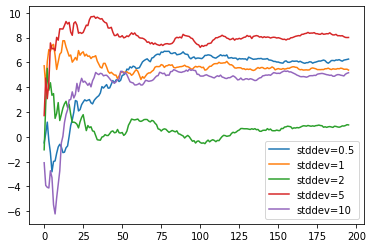

In [29]:
for stddev in [0.5, 1, 2, 5, 10]:
    # Create an Env2 object
    UcbEnv = BanditEnv_2(std=std)
    UcbEnv.reset(std=std)

    learn_upper_confident_bound(UcbEnv, 0.3, legend=f'stddev={stddev}', print_means=True)
_ = plt.legend()

#### Compare with Epsylon greedy & optimistic initial value approach

-----------
Learn greedy with exploration 0.33
Results after exploration, best action is 2
Total reward for all iterations: 1078.9324976228365
Total attempts per action: [ 14.  13. 147.  13.  13.]
-----------
Learn greedy with exploration 0.1
Results after exploration, best action is 2
Total reward for all iterations: 1468.8276738831137
Total attempts per action: [  4.   4. 184.   4.   4.]
-----------
Learn with Optimistic value 1000
Results: best action is 2
Total reward for all iterations: 1553.1793337178217
Total attempts per action: [  2.   3. 196.   2.   2.]
-----------
Learn with UCB method and c-value 1
Total reward for all iterations: 1547.1949517688831, and best action is 2
Total attempts per action: [  1.   2. 196.   1.   1.]


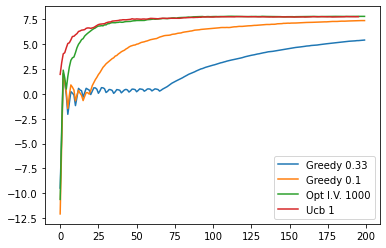

In [30]:
UcbEnv = BanditEnv_2()
UcbEnv.reset()
_ = learn_greedy(UcbEnv, .33)
_ = learn_greedy(UcbEnv, .1)
_ = learn_optimistic(UcbEnv, 1000)
_ = learn_upper_confident_bound(UcbEnv, 1)
_ = plt.legend()

### EXTRA: non-stationary bandits

In the following you have to deal with non-stationary bandits. This means that the expected reward is not stationary and will change over time. 
in the BanditEnv_3, the initial expected rewards will change with a constant after each action.

Figure out the best strategy to optimize the total reward after 200 actions.

- **The optimistic initial value seems to be best suited for this, as it can keep iterating and adapting, according to changes**

In [31]:
class BanditEnv_3:
    def __init__(self):
        self.means = np.array([[-10,6,8,0,-2]])
        self.std = 1
        
    def reset(self):
        self.means = np.array([[-10,6,8,0,-2]])
        
    def step(self,action):
        self.action = action
        self.means = self.means + np.array([[0.15,-0.1,-0.15,0.05,0.1]])
        return np.random.normal(self.means[0,self.action], self.std, 1)[0]
    
    def possible_actions(self):
        return np.arange(len(self.means), dtype=int)

-----------
Learn greedy with exploration 0.33
Results after exploration, best action is 0
Total reward for all iterations: 1019.5341172040372
Total attempts per action: [200.]
-----------
Learn greedy with exploration 0.1
Results after exploration, best action is 0
Total reward for all iterations: 6999.522973077269
Total attempts per action: [200.]
-----------
Learn greedy with exploration 0.8
Results after exploration, best action is 0
Total reward for all iterations: 13027.545849805741
Total attempts per action: [200.]
-----------
Learn with Optimistic value 1000
Results: best action is 0
Total reward for all iterations: 19002.00176813574
Total attempts per action: [201.]


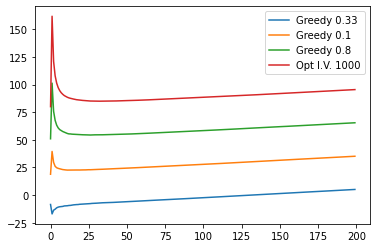

In [32]:
# create an env3 environment
env = BanditEnv_3()
env.reset()

# solve the environment (for 200 steps)
_ = learn_greedy(env, .33)
_ = learn_greedy(env, .1)
_ = learn_greedy(env, .8)
_ = learn_optimistic(env, 1000)
_ = plt.legend()

## Server latencies

You have to make 1000 webpage requests. There are 25 servers with different latencies to choose from. 
Your task is to come up with a clever strategy to reduce the cumulative latency of these 1000 webpage requests.
The file 'latencies.csv' contains these 1000 different request. 
It's important to know that in a practical situation you would not have access to this data and requests will be made sequentially.
Use a multi-armed bandit to find the best strategy to minimize the total latency over these 1000 requests. Again, it's not allowed to process and statistically analyse the data in advance.

1. Try and optimize different types of bandits: epsilon-greedy, optimistic initial value, upper confidence bound.
    - **I just created a new environment, using the same 'contract/interface' as the existing Environments.  And this allowed me to call the existing generic functions, without requiring any adaptions**
2. Compare these bandits in terms of total cumulated reward (or regret). Make a graph to visualize this.
    - **See below**
3. Make graphs showing how often each bandit was chosen.
    - **The scatter plot at the end shows the different choices per server, per approach**

EXTRA: program a bayesian badit to solve the latency problem.

In [33]:
class ServerEnvironment:
    _current_request: int = 0
    
    def __init__(self, file: str = 'data/latencies.csv'):
        self.filename = file
        self.reset()
        
    def reset(self):
        self.requests = pd.read_csv(self.filename).to_numpy()
        self.request_count = self.requests.shape[0]
        self.action_count = self.requests.shape[1]
        self._current_request = 0
        
    def step(self,action):
        self.action = action
        self._current_request = self._current_request + 1
        request_id = self._current_request % self.request_count
        # As the reward should be higher when latency is lower, we will return reward
        # By dividing 100 by the latency
        return 100 / self.requests[request_id, action]
    
    def possible_actions(self):
        return np.arange(self.action_count, dtype=int)

In [34]:
ServEnv = ServerEnvironment()
ServEnv.reset()

In [40]:
print(ucb_means[:,1])
print(np.arange(5))

[  1.   1.   1. 172.   1.   6.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
[0 1 2 3 4]


-----------
Learn greedy with exploration 0.1
Results after exploration, best action is 3
Total reward for all iterations: 691.9860064196832
Total attempts per action: [  1.   1.   1. 181.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   0.   0.   0.   0.   0.]
-----------
Learn with epsilon greedy 0.33
Total reward for all iterations: 266.97666969227026, and best action is 5
Total attempts per action: [ 4.  5.  2.  0.  3. 50.  2.  3.  4.  4.  1.  6.  2.  2.  4.  1.  4.  4.
  1.  3. 21. 56.  1. 14.  3.]
-----------
Learn with epsilon greedy 0.33
Total reward for all iterations: 440.1034295978816, and best action is 3
Total attempts per action: [  6.   5.  19. 107.   4.   0.   5.   4.   1.   2.   4.   3.   4.   2.
   0.   4.   4.  11.   3.   2.   3.   0.   4.   1.   2.]
-----------
Learn with Optimistic value 1000
Results: best action is 3
Total reward for all iterations: 683.3931160404862
Total attempts per action: [  2.   2.   2. 177.   2.   2.   2.  

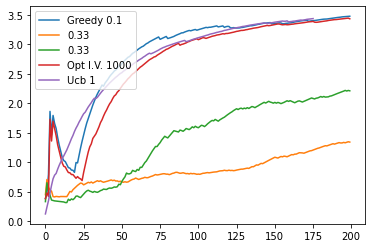

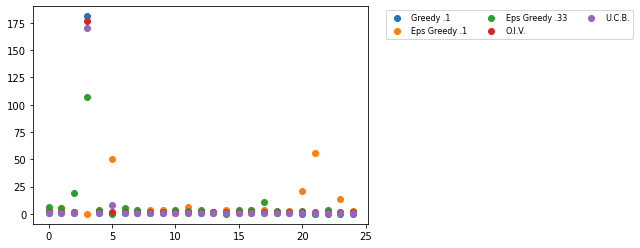

In [46]:
# Server latencies

_, greedy10_means = learn_greedy(ServEnv, .1)
_, epsgreedy10_means = learn_epsgreedy(ServEnv, .33)
_, epsgreedy33_means = learn_epsgreedy(ServEnv, .33)
_, optimistic_means = learn_optimistic(ServEnv, 1000)
_, ucb_means = learn_upper_confident_bound(ServEnv, 1)
_ = plt.legend()
plt.figure(0)
g10 = plt.scatter(ServEnv.possible_actions(), greedy10_means[:,1])
eg10 = plt.scatter(ServEnv.possible_actions(), epsgreedy10_means[:,1])
eg33 = plt.scatter(ServEnv.possible_actions(), epsgreedy33_means[:,1])
o = plt.scatter(ServEnv.possible_actions(), optimistic_means[:,1])
u = plt.scatter(ServEnv.possible_actions(), ucb_means[:,1])
plt.legend((g10, eg10, eg33, o, u),
           ('Greedy .1', 'Eps Greedy .1', 'Eps Greedy .33', 'O.I.V.', 'U.C.B.'),
           scatterpoints=1,
           bbox_to_anchor=(1.04,1), loc="upper left",
           ncol=3,
           fontsize=8)